# Clustering the Dataset

In [97]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from kmodes.kprototypes import KPrototypes

## 1. Load the Dataset

In [60]:
ilpd_indian_liver_patient = fetch_ucirepo(id=225)

X = ilpd_indian_liver_patient.data.features
y = ilpd_indian_liver_patient.data.targets

X = X.dropna()

In [61]:
X

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio
0,65,Female,0.70000,0.10000,187,16,18,6.80000,3.30000,0.90000
1,62,Male,10.90000,5.50000,699,64,100,7.50000,3.20000,0.74000
2,62,Male,7.30000,4.10000,490,60,68,7.00000,3.30000,0.89000
3,58,Male,1.00000,0.40000,182,14,20,6.80000,3.40000,1.00000
4,72,Male,3.90000,2.00000,195,27,59,7.30000,2.40000,0.40000
...,...,...,...,...,...,...,...,...,...,...
578,60,Male,0.50000,0.10000,500,20,34,5.90000,1.60000,0.37000
579,40,Male,0.60000,0.10000,98,35,31,6.00000,3.20000,1.10000
580,52,Male,0.80000,0.20000,245,48,49,6.40000,3.20000,1.00000
581,31,Male,1.30000,0.50000,184,29,32,6.80000,3.40000,1.00000


## 2. Preprocessing

In [62]:
X.isna().sum() # Check for missing values (there's none)

Age          0
Gender       0
TB           0
DB           0
Alkphos      0
Sgpt         0
Sgot         0
TP           0
ALB          0
A/G Ratio    0
dtype: int64

In [65]:
# Build preprocessing pipeline

numeric_features = ['Age', 'TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot', 'TP', 'ALB', 'A/G Ratio']
categorical_features = ['Gender']
all_columns = numeric_features + categorical_features

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features), # RobustScaler?
        #('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough',
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [66]:
X_processed = pipeline.fit_transform(X)
X_processed = pd.DataFrame(X_processed, columns=all_columns, index=X.index)

X_processed

,Age,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Gender
0,1.24740,-0.42032,-0.49541,-0.42887,-0.35583,-0.31911,0.29372,0.20345,-0.14739,Female
1,1.06231,1.21894,1.42352,1.67508,-0.09357,-0.03596,0.93965,0.07746,-0.64846,Male
2,1.06231,0.64038,0.92602,0.81624,-0.11543,-0.14646,0.47827,0.20345,-0.17871,Male
3,0.81551,-0.37211,-0.38881,-0.44942,-0.36676,-0.31221,0.29372,0.32943,0.16578,Male
4,1.67929,0.09396,0.17977,-0.39600,-0.29573,-0.17754,0.75510,-0.93041,-1.71324,Male
...,...,...,...,...,...,...,...,...,...,...
578,0.93891,-0.45246,-0.49541,0.85734,-0.33398,-0.26386,-0.53676,-1.93829,-1.80719,Male
579,-0.29507,-0.43639,-0.49541,-0.79460,-0.25202,-0.27422,-0.44449,0.07746,0.47895,Male
580,0.44532,-0.40425,-0.45988,-0.19053,-0.18099,-0.21207,-0.07538,0.07746,0.16578,Male
581,-0.85036,-0.32389,-0.35327,-0.44120,-0.28480,-0.27077,0.29372,0.32943,0.16578,Male


In [94]:
X_numeric = X_processed[numeric_features] # Remove Gender (temporarily)

X_numeric

,Age,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio
0,1.24740,-0.42032,-0.49541,-0.42887,-0.35583,-0.31911,0.29372,0.20345,-0.14739
1,1.06231,1.21894,1.42352,1.67508,-0.09357,-0.03596,0.93965,0.07746,-0.64846
2,1.06231,0.64038,0.92602,0.81624,-0.11543,-0.14646,0.47827,0.20345,-0.17871
3,0.81551,-0.37211,-0.38881,-0.44942,-0.36676,-0.31221,0.29372,0.32943,0.16578
4,1.67929,0.09396,0.17977,-0.39600,-0.29573,-0.17754,0.75510,-0.93041,-1.71324
...,...,...,...,...,...,...,...,...,...
578,0.93891,-0.45246,-0.49541,0.85734,-0.33398,-0.26386,-0.53676,-1.93829,-1.80719
579,-0.29507,-0.43639,-0.49541,-0.79460,-0.25202,-0.27422,-0.44449,0.07746,0.47895
580,0.44532,-0.40425,-0.45988,-0.19053,-0.18099,-0.21207,-0.07538,0.07746,0.16578
581,-0.85036,-0.32389,-0.35327,-0.44120,-0.28480,-0.27077,0.29372,0.32943,0.16578


## 3. Clustering using K-Prototype

In [67]:
categorical_idx = [X_processed.columns.get_loc(col) for col in categorical_features]

categorical_idx

[9]

In [68]:
kproto = KPrototypes(n_clusters=3, init='Cao', random_state=42)

X_to_cluster = X_processed[numeric_features + categorical_features].to_numpy()

X_to_cluster

array([[1.2474026367725006, -0.42031984192063543, -0.4954141547925456,
        ..., 0.20344648859418601, -0.1473897423487682, 'Female'],
       [1.0623062434636135, 1.2189358685824943, 1.423517827831802, ...,
        0.07746197854495242, -0.6484607783557363, 'Male'],
       [1.0623062434636135, 0.6403750295813895, 0.9260169434477115, ...,
        0.20344648859418601, -0.17870668209920373, 'Male'],
       ...,
       [0.4453182657673228, -0.40424870750393815, -0.4598783773365392,
        ..., 0.07746197854495242, 0.1657796551555868, 'Male'],
       [-0.8503564873948877, -0.3238930354204514, -0.35327104496851985,
        ..., 0.3294309986434202, 0.1657796551555868, 'Male'],
       [-0.4184649030074842, -0.3721064386705434, -0.42434259988053274,
        ..., 1.589276099135761, 1.7316266426773619, 'Male']],
      shape=(579, 10), dtype=object)

2/15 - Silhouette Score: 0.481
3/15 - Silhouette Score: 0.244
4/15 - Silhouette Score: 0.262
5/15 - Silhouette Score: 0.266
6/15 - Silhouette Score: 0.208
7/15 - Silhouette Score: 0.208
8/15 - Silhouette Score: 0.213
9/15 - Silhouette Score: 0.217
10/15 - Silhouette Score: 0.204
11/15 - Silhouette Score: 0.174
12/15 - Silhouette Score: 0.178
13/15 - Silhouette Score: 0.197
14/15 - Silhouette Score: 0.188


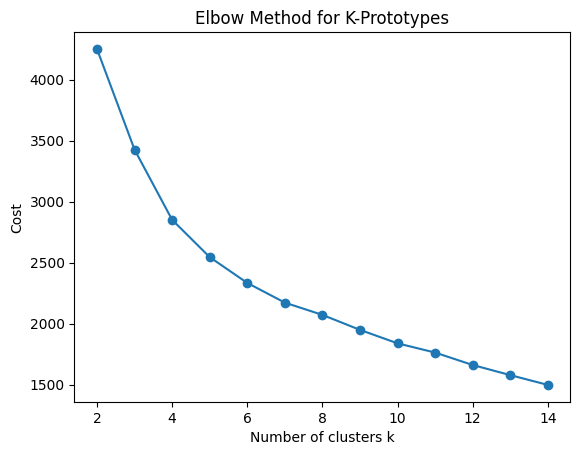

In [95]:
costs = []
max_K = 15
K = range(2, max_K)

for k in K:
    kproto = KPrototypes(n_clusters=k, init='Cao', random_state=42)
    clusters = kproto.fit_predict(X_to_cluster, categorical=categorical_idx)
    costs.append(kproto.cost_)
    sil_score = silhouette_score(X_numeric, clusters)
    print(f"{k}/{max_K} - Silhouette Score: {sil_score:.3f}")

plt.plot(K, costs, marker='o')
plt.xlabel('Number of clusters k')
plt.ylabel('Cost')
plt.title('Elbow Method for K-Prototypes')
plt.show()

In [108]:
chosen_K = [2, 4, 5]

for k in chosen_K:
    kproto = KPrototypes(n_clusters=k, init='Cao', random_state=42)
    clusters = kproto.fit_predict(X_to_cluster, categorical=categorical_idx)

    X[f'{k}-Proto_Cluster'] = clusters

/tmp/ipykernel_51392/3650162301.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f'{k}-Proto_Cluster'] = clusters
/tmp/ipykernel_51392/3650162301.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f'{k}-Proto_Cluster'] = clusters
/tmp/ipykernel_51392/3650162301.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [87]:
X

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Cluster,5-Proto_Cluster,4-Proto_Cluster
0,65,Female,0.70000,0.10000,187,16,18,6.80000,3.30000,0.90000,0,0,1
1,62,Male,10.90000,5.50000,699,64,100,7.50000,3.20000,0.74000,4,4,0
2,62,Male,7.30000,4.10000,490,60,68,7.00000,3.30000,0.89000,0,0,1
3,58,Male,1.00000,0.40000,182,14,20,6.80000,3.40000,1.00000,1,1,2
4,72,Male,3.90000,2.00000,195,27,59,7.30000,2.40000,0.40000,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,60,Male,0.50000,0.10000,500,20,34,5.90000,1.60000,0.37000,0,0,1
579,40,Male,0.60000,0.10000,98,35,31,6.00000,3.20000,1.10000,0,0,2
580,52,Male,0.80000,0.20000,245,48,49,6.40000,3.20000,1.00000,0,0,1
581,31,Male,1.30000,0.50000,184,29,32,6.80000,3.40000,1.00000,1,1,2


## 4. Clustering using GMM

2/15 - Silhouette Score: 0.262
3/15 - Silhouette Score: 0.089
4/15 - Silhouette Score: -0.014
5/15 - Silhouette Score: -0.020
6/15 - Silhouette Score: 0.025
7/15 - Silhouette Score: -0.010
8/15 - Silhouette Score: 0.008
9/15 - Silhouette Score: -0.001
10/15 - Silhouette Score: -0.011
11/15 - Silhouette Score: -0.002
12/15 - Silhouette Score: -0.026
13/15 - Silhouette Score: -0.037
14/15 - Silhouette Score: -0.043


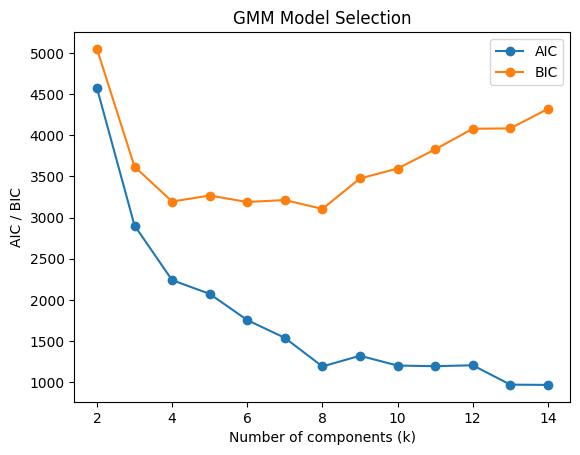

In [93]:
X_data = X_numeric.to_numpy()

aic = []
bic = []
max_K = 15
K = range(2, max_K)

for k in K:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm_labels = gmm.fit_predict(X_data)
    aic.append(gmm.aic(X_data))
    bic.append(gmm.bic(X_data))
    sil_score = silhouette_score(X_numeric, gmm_labels)
    print(f"{k}/{max_K} - Silhouette Score: {sil_score:.3f}")

plt.plot(K, aic, label='AIC', marker='o')
plt.plot(K, bic, label='BIC', marker='o')
plt.xlabel('Number of components (k)')
plt.ylabel('AIC / BIC')
plt.title('GMM Model Selection')
plt.legend()
plt.show()


## 5. Clustering with DBSCAN

eps=0.15 - Clusters=0 - Silhouette=nan
eps=0.28 - Clusters=0 - Silhouette=nan
eps=0.41 - Clusters=4 - Silhouette=0.5742031602703759
eps=0.55 - Clusters=5 - Silhouette=-0.03200887368206105
eps=0.68 - Clusters=3 - Silhouette=0.05299692975254801
eps=0.81 - Clusters=2 - Silhouette=0.234206751163432
eps=0.94 - Clusters=3 - Silhouette=0.055443457981192455
eps=1.07 - Clusters=1 - Silhouette=nan
eps=1.21 - Clusters=2 - Silhouette=0.41514160463814137
eps=1.34 - Clusters=3 - Silhouette=0.29255688198713814
eps=1.47 - Clusters=1 - Silhouette=nan
eps=1.60 - Clusters=1 - Silhouette=nan
eps=1.74 - Clusters=1 - Silhouette=nan
eps=1.87 - Clusters=2 - Silhouette=0.3898713775484834
eps=2.00 - Clusters=1 - Silhouette=nan


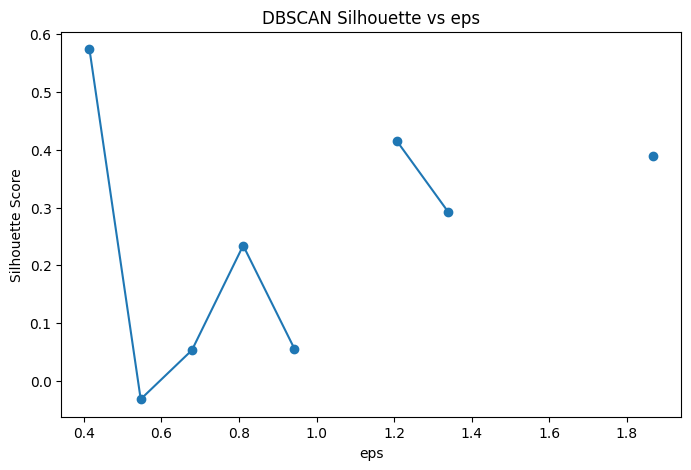

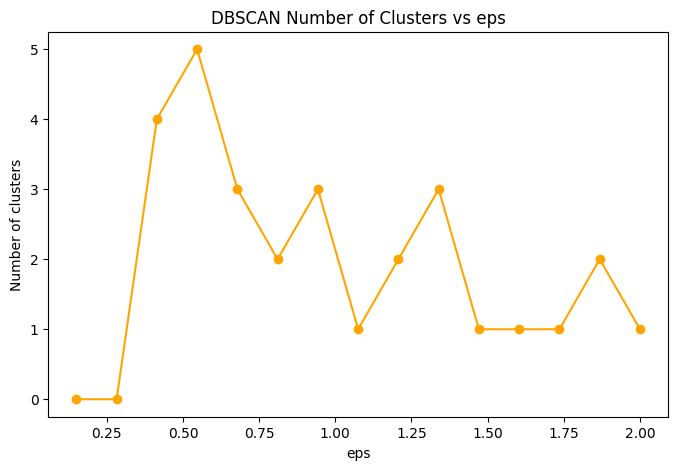

In [101]:
# X_data is already scaled numeric features
X_data = X_numeric.to_numpy()

eps_values = np.linspace(0.15, 2.0, 15)  # try 15 different eps values
min_samples = 5  # keep fixed, or you can vary it

sil_scores = []
n_clusters_list = []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X_data)

    # Count clusters (exclude noise)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_clusters_list.append(n_clusters)

    # Compute silhouette only if >= 2 clusters
    if n_clusters >= 2:
        mask = labels != -1  # exclude noise points
        sil_score = silhouette_score(X_data[mask], labels[mask])
    else:
        sil_score = np.nan  # cannot compute silhouette
    sil_scores.append(sil_score)

    print(f"eps={eps:.2f} - Clusters={n_clusters} - Silhouette={sil_score}")

# Plot silhouette vs eps
plt.figure(figsize=(8,5))
plt.plot(eps_values, sil_scores, marker='o')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.title('DBSCAN Silhouette vs eps')
plt.show()

# Optional: plot number of clusters vs eps
plt.figure(figsize=(8,5))
plt.plot(eps_values, n_clusters_list, marker='o', color='orange')
plt.xlabel('eps')
plt.ylabel('Number of clusters')
plt.title('DBSCAN Number of Clusters vs eps')
plt.show()

In [106]:
db = DBSCAN(eps=1.34, min_samples=5)
db_labels = db.fit_predict(X_data)

# Add cluster labels to original DataFrame
X['DBSCAN_Cluster-eps134'] = db_labels

/tmp/ipykernel_51392/1155565474.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['DBSCAN_Cluster-eps134'] = db_labels


In [109]:
X

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Cluster,5-Proto_Cluster,4-Proto_Cluster,DBSCAN_Cluster-eps041,DBSCAN_Cluster-eps134,2-Proto_Cluster
0,65,Female,0.70000,0.10000,187,16,18,6.80000,3.30000,0.90000,0,0,1,2,0,0
1,62,Male,10.90000,5.50000,699,64,100,7.50000,3.20000,0.74000,4,4,0,-1,0,1
2,62,Male,7.30000,4.10000,490,60,68,7.00000,3.30000,0.89000,0,0,1,-1,0,0
3,58,Male,1.00000,0.40000,182,14,20,6.80000,3.40000,1.00000,1,1,2,2,0,0
4,72,Male,3.90000,2.00000,195,27,59,7.30000,2.40000,0.40000,0,0,1,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,60,Male,0.50000,0.10000,500,20,34,5.90000,1.60000,0.37000,0,0,1,-1,0,0
579,40,Male,0.60000,0.10000,98,35,31,6.00000,3.20000,1.10000,0,0,2,1,0,0
580,52,Male,0.80000,0.20000,245,48,49,6.40000,3.20000,1.00000,0,0,1,-1,0,0
581,31,Male,1.30000,0.50000,184,29,32,6.80000,3.40000,1.00000,1,1,2,-1,0,0


In [111]:
X.to_csv('data/ilpd-clustered.csv', index=False)